# Zero-Shot and Few-Shot Classification for Heart Disease Prediction
Using Azure OpenAI API with `patient_data` text and `label` columns

This notebook demonstrates:
- **Zero-Shot Classification** - No examples provided
- **Few-Shot Classification** - With 5, 10, and 15 examples

## 1. Install Required Packages

In [ ]:
!pip install  pandas scikit-learn matplotlib tqdm

## 2. Import Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from openai import AzureOpenAI
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import time

print("Libraries imported successfully!")

Libraries imported successfully!


## 3. Load Environment Variables & Initialize Azure OpenAI Client

In [ ]:
from openai import OpenAI

# ==============================
#   PUT YOUR API KEY HERE
# ==============================

# ==============================
# Initialize OpenAI Client
# ==============================
client = OpenAI(api_key=API_KEY)

# ==============================
# Model Configuration
# ==============================
MODEL_NAME = "gpt-4.1"
model = MODEL_NAME # Ensure 'model' is also set if used elsewhere
RANDOM_SEED = 42

# Define DEPLOYMENT_NAME for compatibility with get_classification function
# This is set to MODEL_NAME as we are using the OpenAI client
DEPLOYMENT_NAME = MODEL_NAME

print("OpenAI Client initialized successfully!")
print(f"Using Model: {MODEL_NAME}")
print(f"DEPLOYMENT_NAME set to: {DEPLOYMENT_NAME}")

OpenAI Client initialized successfully!
Using Model: gpt-4.1
DEPLOYMENT_NAME set to: gpt-4.1


## 4. Load and Explore Dataset

In [ ]:

# =========================
# 1) Mount Google Drive
# =========================
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from google.colab import drive

# =========================
# 2) Config
# =========================
RANDOM_SEED = 42
SAMPLE_SIZE = 100

# ✅ Put your Drive CSV path here
# CSV_PATH = "/content/main_dataset.csv"
# Example (if you want Heart_Disease.csv):
CSV_PATH = "/content/drive/MyDrive/Project/Dataset/main_dataset.csv" # <--- UPDATE THIS PATH

# =========================
# 3) Load dataset from Drive
# =========================
df_full = pd.read_csv(CSV_PATH)

print(f"Full Dataset Shape: {df_full.shape}")

# If your dataset column is not called "label", change it here
LABEL_COL = "label"
print(f"Full Label Distribution:\n{df_full[LABEL_COL].value_counts()}")

# =========================
# 4) Normalize labels
# =========================
def normalize_label(label: str) -> str:
    """Normalize the label to consistent format."""
    label = str(label).strip().lower()
    if "no heart" in label or "no disease" in label:
        return "No heart Disease"
    elif "heart disease" in label:
        return "Heart Disease"
    return label

df_full[LABEL_COL] = df_full[LABEL_COL].apply(normalize_label)

# =========================
# 5) Balanced sampling
# =========================
random.seed(RANDOM_SEED)

heart_disease_df = df_full[df_full[LABEL_COL] == "Heart Disease"]
no_heart_disease_df = df_full[df_full[LABEL_COL] == "No heart Disease"]

n_per_class = SAMPLE_SIZE // 2

hd_sample = heart_disease_df.sample(
    n=min(n_per_class, len(heart_disease_df)),
    random_state=RANDOM_SEED
)

nhd_sample = no_heart_disease_df.sample(
    n=min(n_per_class, len(no_heart_disease_df)),
    random_state=RANDOM_SEED
)

df = (
    pd.concat([hd_sample, nhd_sample])
      .sample(frac=1, random_state=RANDOM_SEED)
      .reset_index(drop=True)
)

print(f"\n{'='*50}")
print(f"Sampled Dataset Shape: {df.shape}")
print("Sampled Label Distribution:")
print(df[LABEL_COL].value_counts())

# =========================
# 6) Train/Test split (70/30)
# =========================
train_data, test_data = train_test_split(
    df,
    test_size=0.3,
    stratify=df[LABEL_COL],
    random_state=RANDOM_SEED
)

print(f"\n{'='*50}")
print(f"Train data (for few-shot examples): {train_data.shape[0]} samples")
print(f"Test data (for evaluation): {test_data.shape[0]} samples")

print("\nTrain label distribution:")
print(train_data[LABEL_COL].value_counts())

print("\nTest label distribution:")
print(test_data[LABEL_COL].value_counts())
print(f"{'='*50}")

Full Dataset Shape: (1190, 2)
Full Label Distribution:
label
Heart Disease       629
No heart Disease    561
Name: count, dtype: int64

Sampled Dataset Shape: (100, 2)
Sampled Label Distribution:
label
No heart Disease    50
Heart Disease       50
Name: count, dtype: int64

Train data (for few-shot examples): 70 samples
Test data (for evaluation): 30 samples

Train label distribution:
label
No heart Disease    35
Heart Disease       35
Name: count, dtype: int64

Test label distribution:
label
Heart Disease       15
No heart Disease    15
Name: count, dtype: int64


## 5. Define Helper Functions

In [ ]:
# Labels are already normalized in the data loading cell
print("Label values in test data:")
print(test_data['label'].value_counts())

Label values in test data:
label
Heart Disease       15
No heart Disease    15
Name: count, dtype: int64


In [ ]:
def create_zero_shot_prompt(patient_data: str) -> str:
    """Create a zero-shot classification prompt."""
    return f"""You are a medical expert analyzing patient cardiovascular assessment data.

Based on the following patient data, classify whether the patient has heart disease or not.

Patient Data:
{patient_data}

Respond with ONLY one of these two labels:
- "Heart Disease"
- "No heart Disease"

Classification:"""

print("Zero-shot prompt function defined!")

Zero-shot prompt function defined!


In [ ]:
def create_few_shot_prompt(patient_data: str, examples: list) -> str:
    """Create a few-shot classification prompt with given examples."""
    examples_text = ""
    for i, example in enumerate(examples, 1):
        examples_text += f"""
Example {i}:
Patient Data: {example['patient_data']}
Classification: {example['label']}
---"""

    return f"""You are a medical expert analyzing patient cardiovascular assessment data.

Based on the patient data, classify whether the patient has heart disease or not.

Here are some examples:
{examples_text}

Now classify the following patient:

Patient Data:
{patient_data}

Respond with ONLY one of these two labels:
- "Heart Disease"
- "No heart Disease"

Classification:"""

print("Few-shot prompt function defined!")

Few-shot prompt function defined!


In [ ]:
def get_classification(prompt: str) -> str:
    """Get classification from Azure OpenAI API."""
    try:
        response = client.chat.completions.create(
            model=DEPLOYMENT_NAME,
            messages=[
                {"role": "system", "content": "You are a medical classification assistant. Respond only with the exact classification label."},
                {"role": "user", "content": prompt}
            ],
            temperature=0,
            max_tokens=20
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"API Error: {e}")
        return "Error"

print("Classification function defined!")

Classification function defined!


In [ ]:
def select_balanced_examples(train_df: pd.DataFrame, n_examples: int) -> list:
    """Select balanced examples for few-shot learning from training data."""
    # Separate by label
    heart_disease = train_df[train_df['label'] == 'Heart Disease']
    no_heart_disease = train_df[train_df['label'] == 'No heart Disease']

    # Select balanced samples
    n_per_class = n_examples // 2

    hd_samples = heart_disease.sample(n=min(n_per_class, len(heart_disease)), random_state=RANDOM_SEED)
    nhd_samples = no_heart_disease.sample(n=min(n_per_class, len(no_heart_disease)), random_state=RANDOM_SEED)

    examples = []
    for _, row in pd.concat([hd_samples, nhd_samples]).iterrows():
        examples.append({
            'patient_data': row['patient_data'][:1500],  # Truncate for token limit
            'label': row['label']
        })

    random.shuffle(examples)
    return examples

print("Example selection function defined!")

Example selection function defined!


In [ ]:
def evaluate_and_display(true_labels: list, predictions: list, method_name: str):
    """Evaluate predictions and display results."""
    print(f"\n{'='*60}")
    print(f"Results for: {method_name}")
    print('='*60)

    # Classification Report
    print("\nClassification Report:")
    print("-" * 40)
    labels = ['Heart Disease', 'No heart Disease']
    report = classification_report(true_labels, predictions, labels=labels, zero_division=0)
    print(report)

    # Confusion Matrix
    print("\nConfusion Matrix:")
    print("-" * 40)
    cm = confusion_matrix(true_labels, predictions, labels=labels)

    # Plot confusion matrix
    fig, ax = plt.subplots(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Heart Disease', 'No Heart Disease'])
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    ax.set_title(f'Confusion Matrix - {method_name}')
    plt.tight_layout()
    plt.show()

    return report, cm

print("Evaluation function defined!")

Evaluation function defined!


## 6. Zero-Shot Classification

In [ ]:
import time

print("="*70)
print("ZERO-SHOT CLASSIFICATION")
print("="*70)
print(f"Testing on {len(test_data)} samples (same test set for all methods)")

predictions_zs = []
true_labels_zs = []

for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="Zero-Shot"):
    patient_data = row['patient_data']
    true_label = row['label']

    prompt = create_zero_shot_prompt(patient_data)
    pred = get_classification(prompt)
    pred = normalize_label(pred)

    predictions_zs.append(pred)
    true_labels_zs.append(true_label)

    # Add small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\nCompleted {len(predictions_zs)} predictions!")

ZERO-SHOT CLASSIFICATION
Testing on 30 samples (same test set for all methods)


Zero-Shot: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Completed 30 predictions!



Results for: Zero-Shot

Classification Report:
----------------------------------------
                  precision    recall  f1-score   support

   Heart Disease       0.61      0.93      0.74        15
No heart Disease       0.86      0.40      0.55        15

        accuracy                           0.67        30
       macro avg       0.73      0.67      0.64        30
    weighted avg       0.73      0.67      0.64        30


Confusion Matrix:
----------------------------------------


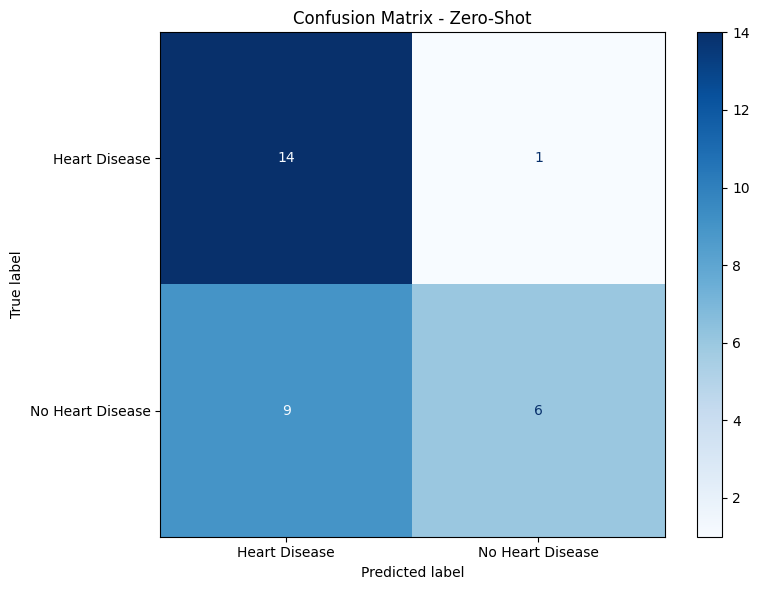

In [ ]:
# Evaluate Zero-Shot Results
report_zs, cm_zs = evaluate_and_display(true_labels_zs, predictions_zs, "Zero-Shot")

## 7. Few-Shot Classification (5 Examples)

In [ ]:
print("="*70)
print("5-SHOT CLASSIFICATION")
print("="*70)

N_SHOTS = 5
examples_5 = select_balanced_examples(train_data, N_SHOTS)
print(f"Selected {len(examples_5)} balanced examples from TRAIN data")
print(f"Testing on {len(test_data)} samples (same test set as zero-shot)")

predictions_5s = []
true_labels_5s = []

for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="5-Shot"):
    patient_data = row['patient_data']
    true_label = row['label']

    prompt = create_few_shot_prompt(patient_data, examples_5)
    pred = get_classification(prompt)
    pred = normalize_label(pred)

    predictions_5s.append(pred)
    true_labels_5s.append(true_label)

    # Add small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\nCompleted {len(predictions_5s)} predictions!")

5-SHOT CLASSIFICATION
Selected 4 balanced examples from TRAIN data
Testing on 30 samples (same test set as zero-shot)


5-Shot: 100%|██████████| 30/30 [00:30<00:00,  1.00s/it]


Completed 30 predictions!



Results for: 5-Shot

Classification Report:
----------------------------------------
                  precision    recall  f1-score   support

   Heart Disease       0.69      0.73      0.71        15
No heart Disease       0.71      0.67      0.69        15

        accuracy                           0.70        30
       macro avg       0.70      0.70      0.70        30
    weighted avg       0.70      0.70      0.70        30


Confusion Matrix:
----------------------------------------


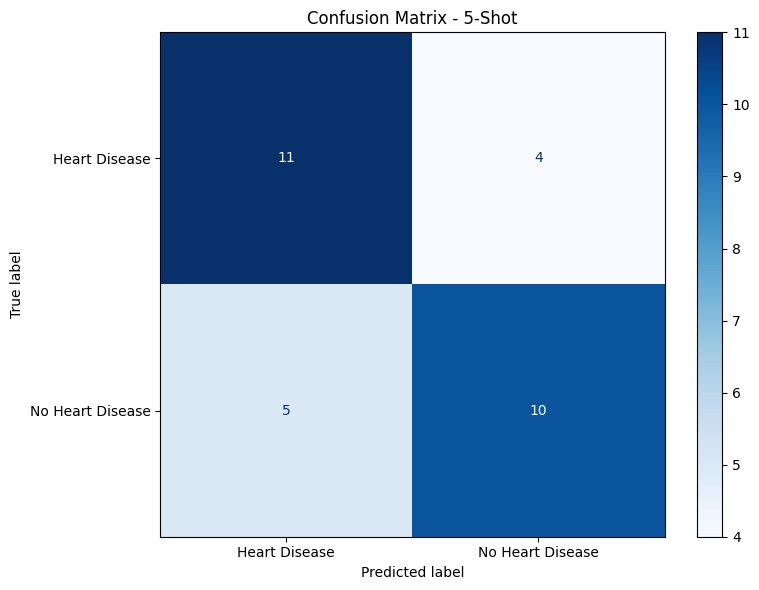

In [ ]:
# Evaluate 5-Shot Results
report_5s, cm_5s = evaluate_and_display(true_labels_5s, predictions_5s, "5-Shot")

## 8. Few-Shot Classification (10 Examples)

In [ ]:
print("="*70)
print("10-SHOT CLASSIFICATION")
print("="*70)

N_SHOTS = 10
examples_10 = select_balanced_examples(train_data, N_SHOTS)
print(f"Selected {len(examples_10)} balanced examples from TRAIN data")
print(f"Testing on {len(test_data)} samples (same test set as zero-shot)")

predictions_10s = []
true_labels_10s = []

for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="10-Shot"):
    patient_data = row['patient_data']
    true_label = row['label']

    prompt = create_few_shot_prompt(patient_data, examples_10)
    pred = get_classification(prompt)
    pred = normalize_label(pred)

    predictions_10s.append(pred)
    true_labels_10s.append(true_label)

    # Add small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\nCompleted {len(predictions_10s)} predictions!")

10-SHOT CLASSIFICATION
Selected 10 balanced examples from TRAIN data
Testing on 30 samples (same test set as zero-shot)


10-Shot: 100%|██████████| 30/30 [00:28<00:00,  1.05it/s]


Completed 30 predictions!



Results for: 10-Shot

Classification Report:
----------------------------------------
                  precision    recall  f1-score   support

   Heart Disease       0.71      0.67      0.69        15
No heart Disease       0.69      0.73      0.71        15

        accuracy                           0.70        30
       macro avg       0.70      0.70      0.70        30
    weighted avg       0.70      0.70      0.70        30


Confusion Matrix:
----------------------------------------


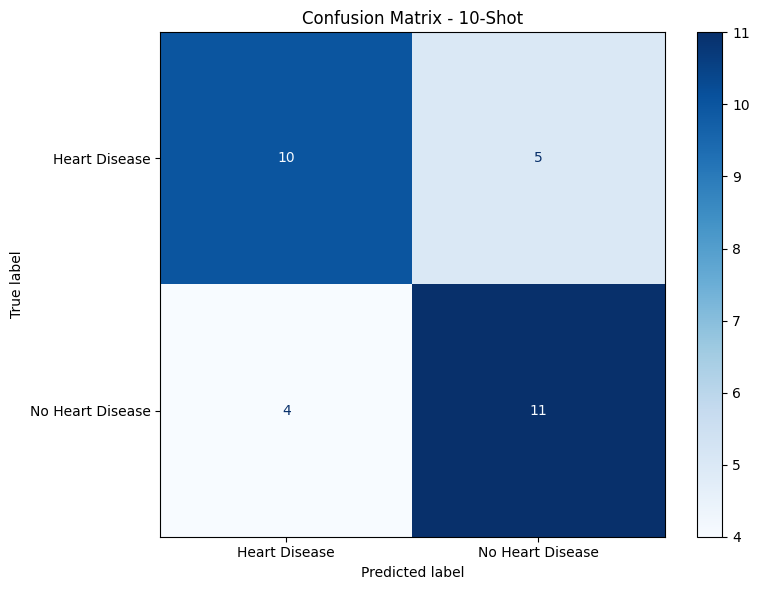

In [ ]:
# Evaluate 10-Shot Results
report_10s, cm_10s = evaluate_and_display(true_labels_10s, predictions_10s, "10-Shot")

In [ ]:
print("="*70)
print("15-SHOT CLASSIFICATION")
print("="*70)

N_SHOTS = 15
examples_15 = select_balanced_examples(train_data, N_SHOTS)
print(f"Selected {len(examples_15)} balanced examples from TRAIN data")
print(f"Testing on {len(test_data)} samples (same test set as zero-shot)")

predictions_15s = []
true_labels_15s = []

for idx, row in tqdm(test_data.iterrows(), total=len(test_data), desc="15-Shot"):
    patient_data = row['patient_data']
    true_label = row['label']

    prompt = create_few_shot_prompt(patient_data, examples_15)
    pred = get_classification(prompt)
    pred = normalize_label(pred)

    predictions_15s.append(pred)
    true_labels_15s.append(true_label)

    # Add small delay to avoid rate limiting
    time.sleep(0.5)

print(f"\nCompleted {len(predictions_15s)} predictions!")

15-SHOT CLASSIFICATION
Selected 14 balanced examples from TRAIN data
Testing on 30 samples (same test set as zero-shot)


15-Shot: 100%|██████████| 30/30 [00:26<00:00,  1.12it/s]


Completed 30 predictions!



Results for: 15-Shot

Classification Report:
----------------------------------------
                  precision    recall  f1-score   support

   Heart Disease       0.73      0.73      0.73        15
No heart Disease       0.73      0.73      0.73        15

        accuracy                           0.73        30
       macro avg       0.73      0.73      0.73        30
    weighted avg       0.73      0.73      0.73        30


Confusion Matrix:
----------------------------------------


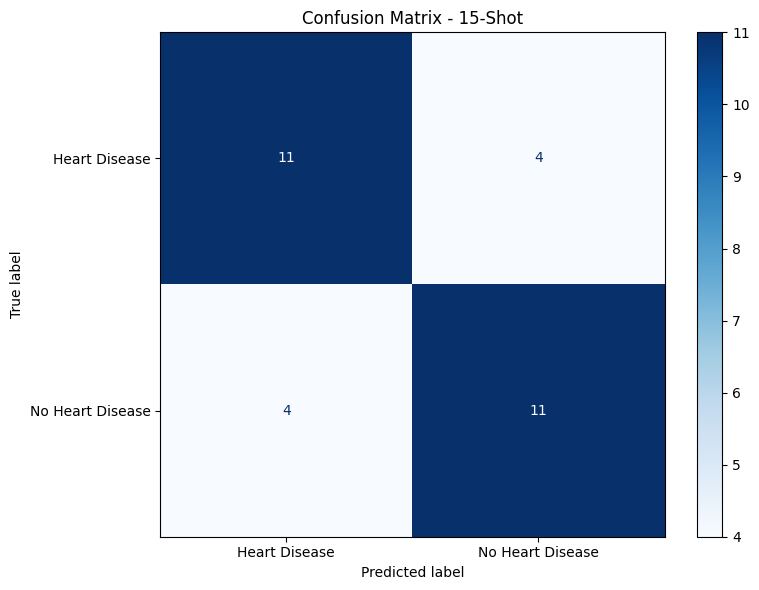

In [ ]:
# Evaluate 10-Shot Results
report_15s, cm_15s = evaluate_and_display(true_labels_15s, predictions_15s, "15-Shot")

In [ ]:
## 10. Summary Comparison

Summary DataFrame:
      Method  Accuracy  Precision (HD)  Recall (HD)  F1-Score (HD)
0  Zero-Shot  0.666667        0.608696     0.933333       0.736842
1     5-Shot  0.700000        0.687500     0.733333       0.709677
2    10-Shot  0.700000        0.714286     0.666667       0.689655
3    15-Shot  0.733333        0.733333     0.733333       0.733333


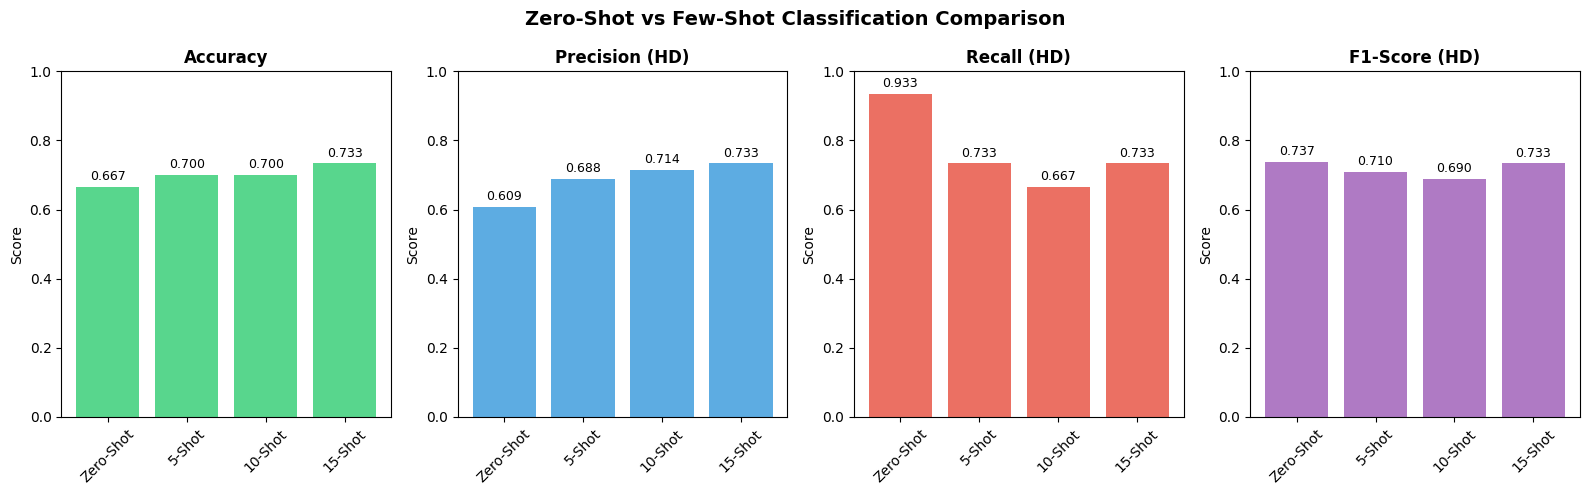

In [ ]:
# Create summary DataFrame
labels = ['Heart Disease', 'No heart Disease']
summary_data = []

for method, true_labels, predictions in [
    ('Zero-Shot', true_labels_zs, predictions_zs),
    ('5-Shot', true_labels_5s, predictions_5s),
    ('10-Shot', true_labels_10s, predictions_10s),
    ('15-Shot', true_labels_15s, predictions_15s),
]:
    # Normalize predictions to handle any unexpected label formats
    normalized_predictions = [normalize_label(p) for p in predictions]
    acc = accuracy_score(true_labels, normalized_predictions)
    prec = precision_score(true_labels, normalized_predictions, pos_label='Heart Disease', zero_division=0)
    rec = recall_score(true_labels, normalized_predictions, pos_label='Heart Disease', zero_division=0)
    f1 = f1_score(true_labels, normalized_predictions, pos_label='Heart Disease', zero_division=0)
    summary_data.append({
        'Method': method,
        'Accuracy': acc,
        'Precision (HD)': prec,
        'Recall (HD)': rec,
        'F1-Score (HD)': f1
    })

summary_df = pd.DataFrame(summary_data)
print("Summary DataFrame:")
print(summary_df)

# Create comparison visualization
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
methods = summary_df['Method'].tolist()
metrics = ['Accuracy', 'Precision (HD)', 'Recall (HD)', 'F1-Score (HD)']
colors = ['#2ecc71', '#3498db', '#e74c3c', '#9b59b6']

for i, metric in enumerate(metrics):
    values = summary_df[metric].tolist()
    axes[i].bar(methods, values, color=colors[i], alpha=0.8)
    axes[i].set_title(metric, fontsize=12, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel('Score')
    axes[i].tick_params(axis='x', rotation=45)
    for j, v in enumerate(values):
        axes[i].text(j, v + 0.02, f'{v:.3f}', ha='center', fontsize=9)

plt.suptitle('Zero-Shot vs Few-Shot Classification Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
# Save summary to CSV
summary_df.to_csv('classification_results_summary.csv', index=False)
print("Summary saved to: classification_results_summary.csv")
print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETED!")
print("="*70)

Summary saved to: classification_results_summary.csv

ALL EXPERIMENTS COMPLETED!
